In [1]:
# Livrable 2 - Traitement d'images



## 1. Chargement des données et constitution du jeu de données

In [2]:
%load_ext tensorboard

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
import time
import pandas as pd
import keras_tuner as kt
import tensorboard
from datetime import datetime
from packaging import version
from tensorflow.keras import regularizers


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
folder = pathlib.Path().resolve()
data_dir = str(folder / "data/Photo")

In [4]:
image_h = 180
image_w = 180
batch_s = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*.jpg')))
print(image_count)

list_ds = tf.data.Dataset.list_files(str(data_dir/'*.jpg'))

val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

10000
8000
2000


In [6]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [image_h, image_w])

def process_path(file_path):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img

In [7]:
train = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [8]:
def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), image_w, image_h, 3))
    return array


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.2
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [9]:
# Loop through unbatched data
def unlabel(data, dataset):
    for image in dataset.as_numpy_iterator():
      data.append(image)

train_data, val_data = [], []
unlabel(train_data, train)
unlabel(val_data, val)
data_train = np.array(train_data, dtype=np.float32)
data_val = np.array(val_data, dtype=np.float32)

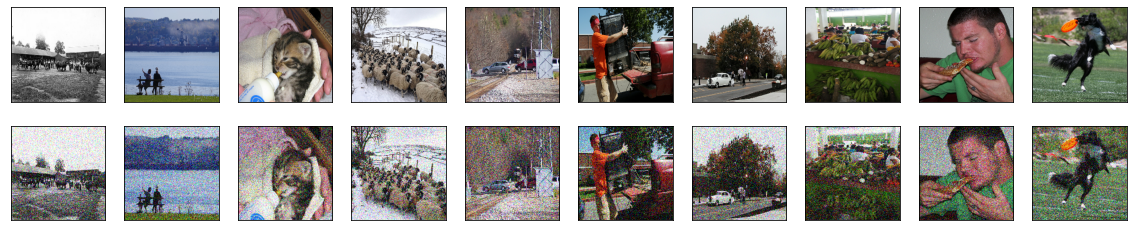

In [10]:
# Normalize and reshape the data
train_data = preprocess(data_train)
test_data = preprocess(data_val)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

In [11]:
# Configurations principales de nos modèles
IMG_SIZE          = 180                # taille coté final d'une image en pixel (ici 28x28)
NB_EPOCHS_DENOISE = 10              # nombre epoch alogithme debruiter
BATCH_SIZE        = 128               # taille batch de traitement
SAV_MODEL_DENOISE = "denoiser.h5"     # sauvegarde du modele de debruitage

In [12]:
input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = keras.Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 90, 90, 32)       9248  

In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint("autoencoder/save_at_2_{epoch}.h5"),
    tf.keras.callbacks.TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)
]

In [15]:
# Train the model
history = autoencoder.fit(noisy_train_data, train_data,
                epochs=NB_EPOCHS_DENOISE,
                batch_size=BATCH_SIZE,
                shuffle=True,
                validation_data=(noisy_test_data, test_data),
                callbacks=callbacks
                )

Epoch 1/10
63/63 [==============================] - 307s 5s/step - loss: 0.6011 - accuracy: 0.4676 - val_loss: 0.5466 - val_accuracy: 0.4934
Epoch 2/10
63/63 [==============================] - 254s 4s/step - loss: 0.5387 - accuracy: 0.5484 - val_loss: 0.5323 - val_accuracy: 0.6198
Epoch 3/10
63/63 [==============================] - 321s 5s/step - loss: 0.5298 - accuracy: 0.6404 - val_loss: 0.5292 - val_accuracy: 0.6475
Epoch 4/10
63/63 [==============================] - 281s 4s/step - loss: 0.5279 - accuracy: 0.6478 - val_loss: 0.5280 - val_accuracy: 0.6461
Epoch 5/10
63/63 [==============================] - 280s 4s/step - loss: 0.5267 - accuracy: 0.6524 - val_loss: 0.5268 - val_accuracy: 0.6494
Epoch 6/10
63/63 [==============================] - 280s 4s/step - loss: 0.5259 - accuracy: 0.6531 - val_loss: 0.5262 - val_accuracy: 0.6566
Epoch 7/10
63/63 [==============================] - 298s 5s/step - loss: 0.5253 - accuracy: 0.6606 - val_loss: 0.5270 - val_accuracy: 0.6654
Epoch 8/10
63

In [19]:
history_2 = autoencoder.fit(noisy_train_data, train_data,
                epochs=40,
                batch_size=BATCH_SIZE,
                shuffle=True,
                validation_data=(noisy_test_data, test_data),
                callbacks=callbacks
                )

Epoch 1/40
63/63 [==============================] - 323s 5s/step - loss: 0.5227 - accuracy: 0.7193 - val_loss: 0.5230 - val_accuracy: 0.7234
Epoch 2/40
63/63 [==============================] - 321s 5s/step - loss: 0.5223 - accuracy: 0.7215 - val_loss: 0.5227 - val_accuracy: 0.7190
Epoch 3/40
63/63 [==============================] - 277s 4s/step - loss: 0.5221 - accuracy: 0.7227 - val_loss: 0.5227 - val_accuracy: 0.7174
Epoch 4/40
63/63 [==============================] - 258s 4s/step - loss: 0.5219 - accuracy: 0.7232 - val_loss: 0.5228 - val_accuracy: 0.7167
Epoch 5/40
63/63 [==============================] - 277s 4s/step - loss: 0.5217 - accuracy: 0.7245 - val_loss: 0.5221 - val_accuracy: 0.7196
Epoch 6/40
63/63 [==============================] - 263s 4s/step - loss: 0.5215 - accuracy: 0.7247 - val_loss: 0.5225 - val_accuracy: 0.7263
Epoch 7/40
63/63 [==============================] - 262s 4s/step - loss: 0.5213 - accuracy: 0.7250 - val_loss: 0.5218 - val_accuracy: 0.7275
Epoch 8/40
63

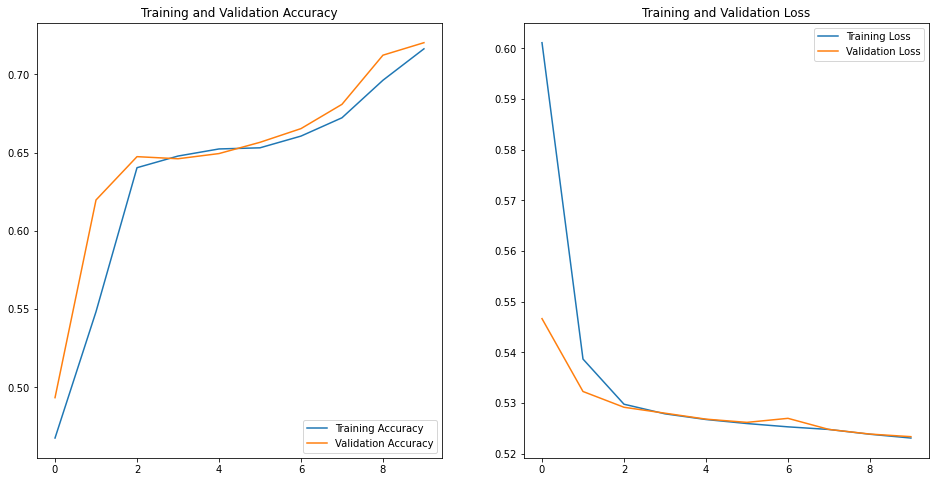

In [17]:
# Visualisation des pertes d'apprentissage (Train) et de validation (Test)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
# save the model
autoencoder.save(SAV_MODEL_DENOISE)

In [20]:
decoded_imgs = autoencoder.predict(noisy_test_data)

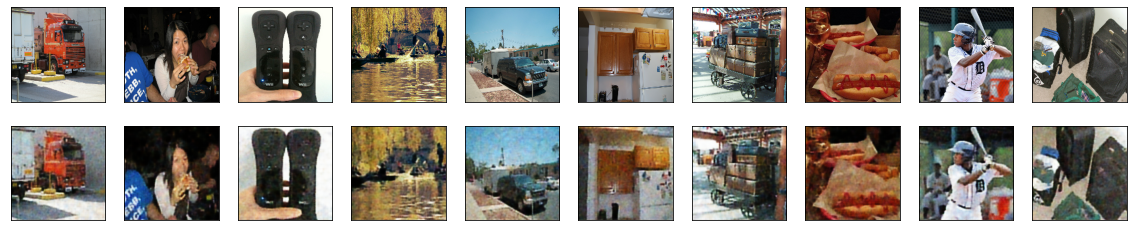

In [22]:
display(test_data, decoded_imgs)